## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.9 MB/s 
     |████████████████████████████████| 212 kB 74.8 MB/s 


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [7]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [8]:
tweets,labels=get_tweet(train)

In [9]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer=  Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

<function matplotlib.pyplot.show>

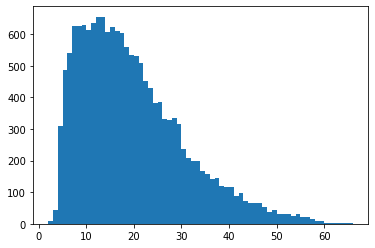

In [14]:
lengths=[len(t.split(' '))for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))  
plt.show

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
maxlen=50

In [17]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [18]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [19]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [20]:
classes=set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

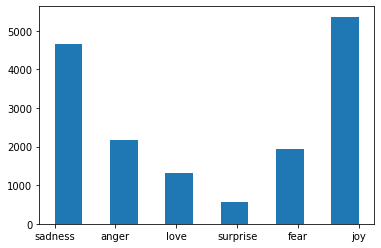

In [21]:
plt.hist(labels,bins=11)
plt.show()

In [22]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())
class_to_index

{'anger': 4, 'fear': 2, 'joy': 0, 'love': 5, 'sadness': 3, 'surprise': 1}

In [24]:
index_to_class

{0: 'joy', 1: 'surprise', 2: 'fear', 3: 'sadness', 4: 'anger', 5: 'love'}

In [27]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [28]:
train_labels=names_to_ids(labels)
print(train_labels[0])

3


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [36]:
model=tf.keras.models.Sequential([
    
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(

        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [39]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [40]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [41]:
h=model.fit(
       
            padded_train_seq,train_labels,
            validation_data=(val_seq,val_labels),
            epochs=20,
            callbacks=[
                       tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
            ]
)

Epoch 1/20
500/500 [==============================] - 16s 14ms/step - loss: 1.3483 - accuracy: 0.4516 - val_loss: 0.9258 - val_accuracy: 0.6510
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.6043 - accuracy: 0.7771 - val_loss: 0.5758 - val_accuracy: 0.7985
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3299 - accuracy: 0.8885 - val_loss: 0.4698 - val_accuracy: 0.8390
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2221 - accuracy: 0.9284 - val_loss: 0.4204 - val_accuracy: 0.8660
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1606 - accuracy: 0.9497 - val_loss: 0.4140 - val_accuracy: 0.8770
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1269 - accuracy: 0.9592 - val_loss: 0.4223 - val_accuracy: 0.8785
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1107 - accuracy: 0.9646 - val_loss: 0.4383 - val_accuracy: 0.870

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

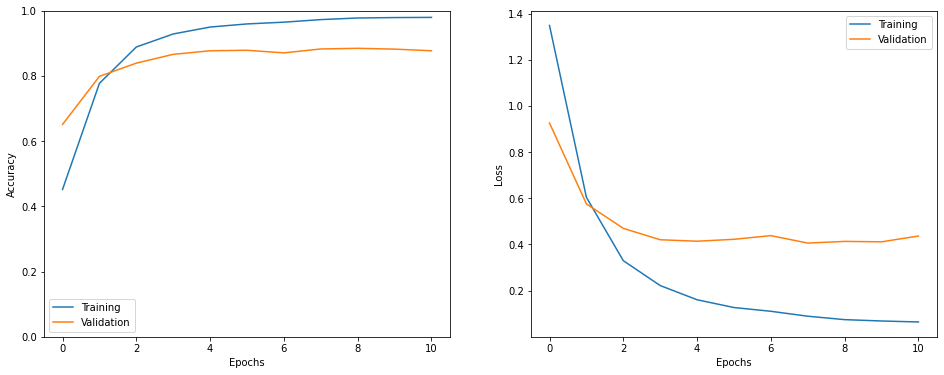

In [42]:
show_history(h)

In [43]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [44]:
model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4114 - accuracy: 0.8745


[0.4113771319389343, 0.8744999766349792]

In [72]:
i=random.randint(0,len(test_labels)-1)
print('Sentence:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:',pred_class)

Sentence: i am still feeling a bit dull from the loss of sleep and am trying to sleep in each morning as possible
Emotion: sadness
Predicted Emotion: sadness
